In [1]:
import json
import os
import re
import glob
import copy
import pandas as pd
from datetime import datetime

with open('../activities_map.json') as f:
    activities_map = json.load(f)

def is_match_in_activity_list(activity_list, activity):
    for activity_name in activity_list:
        if activity_name.endswith(activity):
            return True

    return False

def get_activity_coverage(app_name, droidbot_result_path):
    states_in_utg = set()
    assert os.path.exists(droidbot_result_path), f'{droidbot_result_path} does not exist'
    
    if os.path.exists(os.path.join(droidbot_result_path, 'utg.js')):
        with open(os.path.join(droidbot_result_path, 'utg.js')) as f:
            content = f.readlines()
        states_in_utg = set()
        for line in content:
            line = line.strip()
            if line.startswith('"image":'):
                state_tag = line.split('states/screen_')[-1].split('.png')[0]
                states_in_utg.add(f'state_{state_tag}.json')

    state_files = sorted(glob.glob(os.path.join(droidbot_result_path, 'states', '*.json')))

    if len(states_in_utg) > 0:
        state_files = [state_file for state_file in state_files if os.path.basename(state_file) in states_in_utg]

    covered_activities_so_far = set()
    timeline = []
    start_time = None
    for state_file in state_files:
        with open(state_file) as f:
            state = json.load(f)
        foreground_activity = state['foreground_activity']
        if foreground_activity.endswith('}'):
            foreground_activity = foreground_activity[:-1]
        foreground_activity = foreground_activity.split('/')[-1]
        if is_match_in_activity_list(activities_map[app_name], foreground_activity):
            covered_activities_so_far.add(foreground_activity)

        timestamp = os.path.basename(state_file).removeprefix('state_').removesuffix('.json')
        timestamp = datetime.strptime(timestamp, '%Y-%m-%d_%H%M%S')

        if start_time is None:
            start_time = timestamp

        time_offset = (timestamp - start_time).total_seconds()
        if time_offset > 7200:
            break

        timeline.append((timestamp, len(covered_activities_so_far)))

    return timeline, len(activities_map[app_name])


def get_droidagent_data(droidagent_result_path):
    with open(os.path.join(droidagent_result_path, 'exp_data.json')) as f:
        data = json.load(f)
    return data['visited_activities'], data['app_activities']

"""
detect lines like: // Allowing start of Intent { cmp=de.rampro.activitydiary.debug/de.rampro.activitydiary.ui.generic.ManageActivity }

extract the activity name in Intent { cmp= [here] }
"""
def get_monkey_data(app_name):
    output_path = f'../baselines/monkey/{app_name}'
    monkey_log_path = glob.glob(os.path.join(output_path, '*/monkey.log'))
    assert len(monkey_log_path) == 1

    with open(monkey_log_path[0]) as f:
        content = f.readlines()

    activities = set()
    for line in content:
        line = line.strip()
        if line.startswith('// Allowing start of Intent { cmp='):
            activity_name = re.findall(r'cmp=(.*?)\}', line)[0]
            activity_name = activity_name.split('/')[-1].strip()
            if is_match_in_activity_list(activities_map[app_name], activity_name):
                activities.add(activity_name)

    return activities


In [2]:
rows = []

for project in os.listdir('../data/'):
    if project == 'QuickChat':
        continue
    if project == '.keep':
        continue
    if project == '.DS_Store':
        continue

    path = {
        'droidagent': os.path.join('../data/', project),
        'droidbot': os.path.join('../baselines/', 'droidbot', project),
        'gptdroid': os.path.join('../baselines/', 'gptdroid', project)
    }

    humanoid_result_path = glob.glob(f'../baselines/humanoid/{project}/*')
    assert len(humanoid_result_path) == 1
    humanoid_result_path = humanoid_result_path[0]
    path['humanoid'] = humanoid_result_path
    
    num_all_activities = len(activities_map[project])

    for technique in ['droidagent', 'droidbot', 'humanoid', 'gptdroid']:
        timeline, _ = get_activity_coverage(project, path[technique])
        print(path[technique], len(timeline))

        rows.append({
            'App Name': project,
            'coverage': timeline[-1][1]/num_all_activities,
            'covered_num': timeline[-1][1],
            'technique': technique,
            'total': num_all_activities,
        })

    rows.append({
        'App Name': project,
        'coverage': len(get_monkey_data(project))/num_all_activities,
        'covered_num': len(get_monkey_data(project)),
        'technique': 'monkey',
        'total': num_all_activities,
    })
    
    rows.append({
        'App Name': project,
        'coverage': 1,
        'covered_num': num_all_activities,
        'technique': 'total',
        'total': num_all_activities,
    })
    

df = pd.DataFrame(rows)
df

../data/Phonograph 103
../baselines/droidbot/Phonograph 558
../baselines/humanoid/Phonograph/Phonograph-0.15.0-#112.apk.humandroid.result.emulator-5554.Android7.1#2023-10-09-17-36-46 278
../baselines/gptdroid/Phonograph 142
../data/collect 119
../baselines/droidbot/collect 180
../baselines/humanoid/collect/collect_v2023.2.4.apk.humandroid.result.emulator-5554.Android7.1#2023-10-09-05-33-50 116
../baselines/gptdroid/collect 16
../data/MaterialFB 109
../baselines/droidbot/MaterialFB 1158
../baselines/humanoid/MaterialFB/MaterialFB.apk.humandroid.result.emulator-5554.Android7.1#2023-10-22-08-55-12 390
../baselines/gptdroid/MaterialFB 45
../data/commons 125
../baselines/droidbot/commons 611
../baselines/humanoid/commons/commons-2.11.0-#3244.apk.humandroid.result.emulator-5554.Android7.1#2023-10-22-19-09-33 211
../baselines/gptdroid/commons 128
../data/osmeditor4android 106
../baselines/droidbot/osmeditor4android 339
../baselines/humanoid/osmeditor4android/osmeditor4android-debug-#729.apk.h

,App Name,coverage,covered_num,technique,total
0,Phonograph,0.916667,11,droidagent,12
1,Phonograph,0.583333,7,droidbot,12
2,Phonograph,0.750000,9,humanoid,12
3,Phonograph,0.500000,6,gptdroid,12
4,Phonograph,0.750000,9,monkey,12
...,...,...,...,...,...
85,Omni-Notes,0.250000,3,droidbot,12
86,Omni-Notes,0.500000,6,humanoid,12
87,Omni-Notes,0.416667,5,gptdroid,12
88,Omni-Notes,0.250000,3,monkey,12


In [3]:
df_table = df.pivot(index='App Name', columns='technique', values='covered_num').round(2)

# add total row
df_table.loc['total'] = df_table.sum(axis=0) 
df_table

technique,droidagent,droidbot,gptdroid,humanoid,monkey,total
App Name,,,,,,
APhotoManager,5,5,4,5,5,9
ActivityDiary,10,3,6,5,5,10
AnkiDroid,15,14,6,13,13,22
AntennaPod,4,3,1,5,3,10
Markor,4,4,4,5,5,9
MaterialFB,3,1,3,3,2,4
MyExpenses,15,7,12,7,11,40
Omni-Notes,5,3,5,6,3,12
OpenTracks,16,7,11,10,16,24


In [4]:
%pip install Jinja2
print(df.pivot(index='App Name', columns='technique', values='covered_num').round(2).to_latex())


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
\begin{tabular}{lrrrrrr}
\toprule
technique & droidagent & droidbot & gptdroid & humanoid & monkey & total \\
App Name &  &  &  &  &  &  \\
\midrule
APhotoManager & 5 & 5 & 4 & 5 & 5 & 9 \\
ActivityDiary & 10 & 3 & 6 & 5 & 5 & 10 \\
AnkiDroid & 15 & 14 & 6 & 13 & 13 & 22 \\
AntennaPod & 4 & 3 & 1 & 5 & 3 & 10 \\
Markor & 4 & 4 & 4 & 5 & 5 & 9 \\
MaterialFB & 3 & 1 & 3 & 3 & 2 & 4 \\
MyExpenses & 15 & 7 & 12 & 7 & 11 & 40 \\
Omni-Notes & 5 & 3 & 5 & 6 & 3 & 12 \\
OpenTracks & 16 & 7 & 11 & 10 & 16 & 24 \\
Phonograph & 11 & 7 & 6 & 9 & 9 & 12 \\
Scarlet-Notes & 3 & 3 & 4 & 3 & 3 & 8 \\
collect & 13 & 12 & 2 & 9 & 9 & 37 \\
commons & 14 & 11 & 7 & 12 & 5 & 17 \\
openlauncher & 6 & 2 & 3 & 3 & 4 & 7 \\
osmeditor4android & 9 & 5 & 6 & 12 & 8 & 18 \\
\bottomrule
\end{tabular}



In [5]:
# sort project by alphabetical order
df = df.sort_values(by=['App Name', 'technique'])
df.groupby('technique')['coverage'].mean()

technique
droidagent    0.607589
droidbot      0.379749
gptdroid      0.400956
humanoid      0.514203
monkey        0.458128
total         1.000000
Name: coverage, dtype: float64

In [6]:
%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


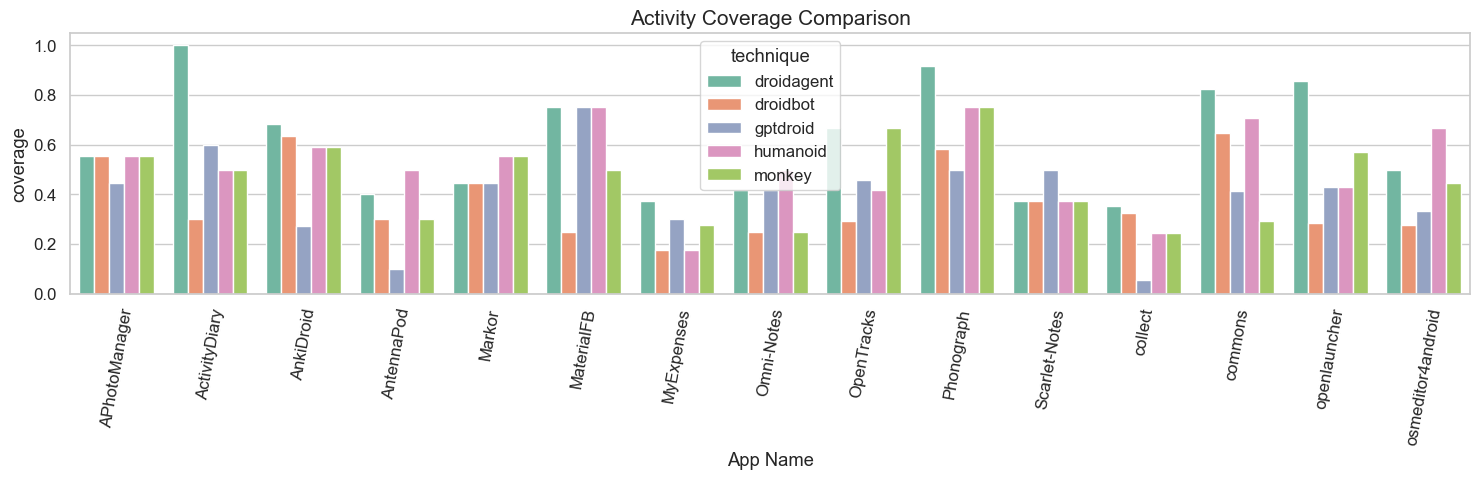

In [7]:
# set figuresize 

sns.set(font_scale=1.1)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15, 5))


sns.barplot(x="App Name", y="coverage", hue="technique", data=df[df.technique != 'total'], width=0.8, palette="Set2", ax=ax)
plt.title('Activity Coverage Comparison', fontsize=15)

# rotate xticks
plt.xticks(rotation=80)
plt.tight_layout()
plt.savefig('./figures/RQ1_activity_coverage_comparison.pdf')

/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12806/1501215937.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="technique", y="coverage", data=df_agg, palette='Set2')
/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12806/1501215937.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


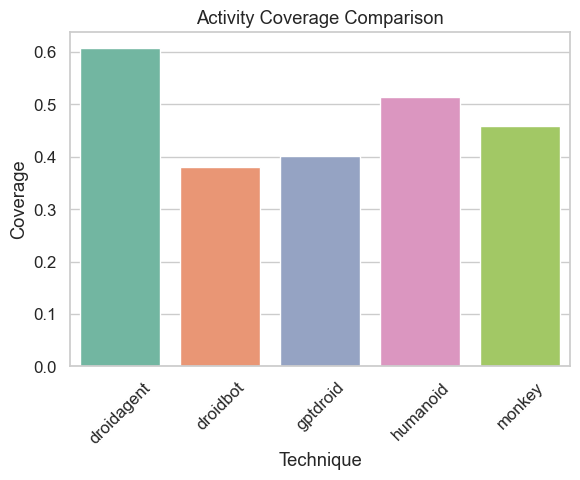

In [8]:
# aggregated 

df_agg = df[df.technique != 'total'].groupby(['technique'])['coverage'].mean().reset_index()
df_agg 


plt.figure(figsize=(6, 5))
plt.title('Activity Coverage Comparison')
ax = sns.barplot(x="technique", y="coverage", data=df_agg, palette='Set2')
ax.set(xlabel='Technique', ylabel='Coverage')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()

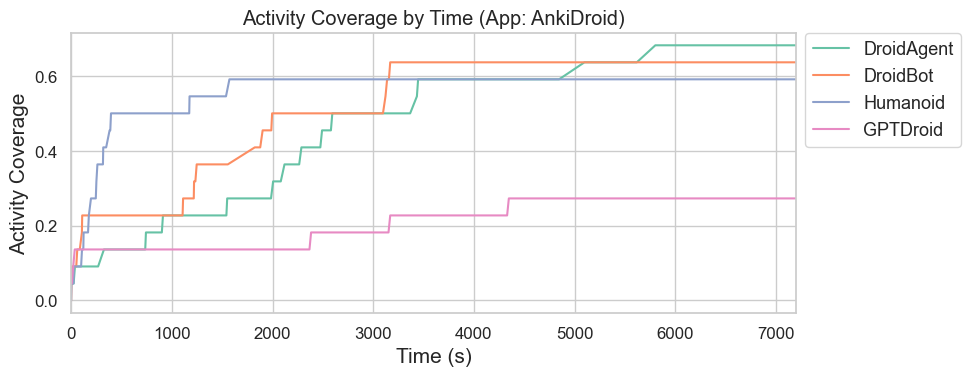

In [9]:
# Visualize activity coverage by time 
import glob
from datetime import datetime
import json
import pandas as pd

def get_activity_coverage_by_time(app_name, result_path, technique='droidagent'):
    timeline, num_all_activities = get_activity_coverage(app_name, result_path)

    time_snapshots = []
    for t, c in timeline:
        time_snapshots.append((t, c/num_all_activities))

    start_time = time_snapshots[0][0]

    rows = []
    for t, c in time_snapshots:
        time_offset = (t - start_time).total_seconds()
        coverage = c

        rows.append({
            'technique': technique,
            'time_offset': time_offset,
            'coverage': coverage,
        })
    
    rows.append({
        'technique': technique,
        'time_offset': 7200,
        'coverage': time_snapshots[-1][1],
    })

    return rows


# Visualize activity coverage by time
import matplotlib.pyplot as plt
import seaborn as sns

def plot_activity_coverage_by_time(app_name, time_snapshot_df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    
    # scale font
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.set_palette("Set2")
    sns.lineplot(x='time_offset', y='coverage', data=time_snapshot_df, ax=ax, hue='technique')
    # set grid none by axis
    ax.grid(which='major', axis='both', linestyle='-')
    # set legend outside 
    ax.legend(loc='upper center', bbox_to_anchor=(1.12, 1.03), ncol=1, fontsize=13)
    ax.set_title('Activity Coverage by Time (App: {})'.format(app_name))
    ax.set_xlim(0, 7200)
    ax.set_xlabel('Time (s)', fontsize=15)
    ax.set_ylabel('Activity Coverage', fontsize=15)
    return ax


app_name = 'AnkiDroid'
all_rows = []

path = {
    'droidagent': os.path.join('../data/', app_name),
    'droidbot': os.path.join('../baselines/', 'droidbot', app_name),
    'gptdroid': os.path.join('../baselines/', 'gptdroid', app_name)
}
humanoid_result_path = glob.glob(f'../baselines/humanoid/{app_name}/*')
assert len(humanoid_result_path) == 1
humanoid_result_path = humanoid_result_path[0]
path['humanoid'] = humanoid_result_path

all_rows.extend(get_activity_coverage_by_time(app_name, path['droidagent'], technique='droidagent'))
all_rows.extend(get_activity_coverage_by_time(app_name, path['droidbot'], technique='droidbot'))
all_rows.extend(get_activity_coverage_by_time(app_name, path['humanoid'], technique='humanoid'))
all_rows.extend(get_activity_coverage_by_time(app_name, path['gptdroid'], technique='gptdroid'))
time_snapshot_df = pd.DataFrame(all_rows)

# rename technique
technique_name_map = {
    'droidagent': 'DroidAgent',
    'droidbot': 'DroidBot',
    'humanoid': 'Humanoid',
    'gptdroid': 'GPTDroid',
}

time_snapshot_df['technique'] = time_snapshot_df['technique'].apply(lambda x: technique_name_map[x])

plot_activity_coverage_by_time(app_name, time_snapshot_df)
plt.tight_layout()
plt.savefig('./figures/RQ1_activity_coverage_by_time.pdf')